In [1]:
import pickle
import pandas as pd  # type: ignore
import matplotlib.pyplot as plt # type: ignore
%matplotlib inline

In [2]:
with open("../tracker_stubs/ball_detection.pkl", "rb") as f:
    ball_positions = pickle.load(f)

In [4]:
ball_positions = [x.get(1,[]) for x in ball_positions]

df_ball_positions = pd.DataFrame(ball_positions, columns=["x1", "y1", "x2", "y2"])

df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()

In [5]:
df_ball_positions

,x1,y1,x2,y2
0,890.699829,613.312988,913.417725,640.145264
1,890.699829,613.312988,913.417725,640.145264
2,875.720001,630.193848,896.978912,654.659851
3,860.740173,647.074707,880.540100,669.174438
4,846.905396,659.924805,866.736328,681.687500
...,...,...,...,...
209,1184.536255,248.085342,1200.577759,265.844910
210,1184.475708,232.469421,1197.976807,246.946930
211,1182.796631,225.405167,1198.041748,241.738083
212,1179.275391,212.167282,1197.061035,230.662033


In [8]:
df_ball_positions["mid_y"] = (df_ball_positions["y1"] + df_ball_positions["y2"]) / 2
df_ball_positions["mid_x"] = (df_ball_positions["x1"] + df_ball_positions["x2"]) / 2
df_ball_positions["mid_y_rolling_mean"] = df_ball_positions["mid_y"].rolling(window=5, min_periods=1, center=False).mean()

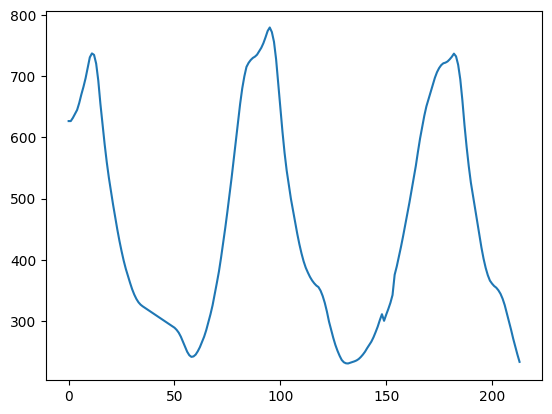

In [11]:
plt.plot(df_ball_positions["mid_y_rolling_mean"])

In [12]:
df_ball_positions["delta_y"] = df_ball_positions["mid_y_rolling_mean"].diff()

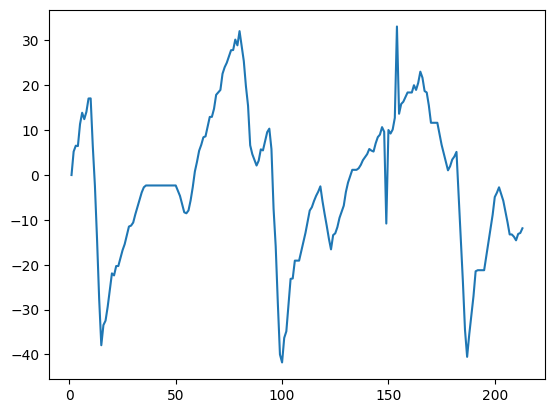

In [13]:
plt.plot(df_ball_positions["delta_y"])

In [15]:
df_ball_positions["ball_hit"] = 0

In [18]:
minimum_change_frames_for_hit = 25

for i in range(1, len(df_ball_positions)- int(minimum_change_frames_for_hit*1.2)):
    negative_position_change = df_ball_positions["delta_y"].iloc[i] > 0 and df_ball_positions["delta_y"].iloc[i+1] < 0
    positive_position_change = df_ball_positions["delta_y"].iloc[i] < 0 and df_ball_positions["delta_y"].iloc[i+1] > 0

    if negative_position_change or positive_position_change:
        change_count = 0
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_in_following_frame = df_ball_positions["delta_y"].iloc[i] > 0 and df_ball_positions["delta_y"].iloc[change_frame] < 0
            positive_position_change_in_following_frame = df_ball_positions["delta_y"].iloc[i] < 0 and df_ball_positions["delta_y"].iloc[change_frame] > 0

            if negative_position_change and negative_position_change_in_following_frame:
                change_count += 1
            elif positive_position_change and positive_position_change_in_following_frame:
                change_count += 1

        if change_count > minimum_change_frames_for_hit-1:
            df_ball_positions["ball_hit"].iloc[i] = 1



C:\Users\arpit\AppData\Local\Temp\ipykernel_17012\699147881.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions["ball_hit"].iloc[i] = 1
C:\Users\arpit\AppData\Local\Temp\ipykernel_17012\699147881.py:19: SettingWithCopyWarn

In [20]:
df_ball_positions[df_ball_positions['ball_hit']==1]

,x1,y1,x2,y2,mid_y,mid_x,mid_y_rolling_mean,delta_y,ball_hit
11,776.433289,716.889893,797.068909,740.049316,728.469604,786.751099,737.374231,6.460059,1
58,923.011230,233.248383,941.921082,252.384186,242.816284,932.466156,241.148158,-2.703717,1
95,615.428284,772.218018,639.058777,799.156677,785.687347,627.243530,779.776813,5.782343,1
132,720.604117,225.081600,735.545236,240.334612,232.708106,728.074677,230.384471,-0.286202,1
149,579.527161,228.504135,594.685547,243.927658,236.215897,587.106354,300.132797,-10.816946,1
182,1294.355713,739.444458,1314.708252,760.240845,749.842651,1304.531982,736.983020,5.161377,1


In [23]:
frame_num_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()

In [24]:
frame_num_with_ball_hits

[11, 58, 95, 132, 149, 182]